In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Step1: Import libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import string
import tensorflow
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

##Step 2: Load the descriptions

In [ ]:

def load_description(text):
    mapping = dict()
    for line in text.split("\n"):
        token = line.split("\t")
        if len(line) < 2:   
            continue
        img_id = token[0].split('.')[0] 
        if img_id not in mapping:
            mapping[img_id] = list()
        mapping[img_id].append(img_des)
    return mapping
  
token_path = '/content/drive/MyDrive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
text = open(token_path, 'r', encoding = 'utf-8').read()
descriptions = load_description(text)
print(descriptions['1000268201_693b08cb0e'])

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


##Step 3: Cleaning the text

In [ ]:
def clean_description(desc):
    for key, des_list in desc.items():
        for i in range(len(des_list)):
            caption = des_list[i]
            caption = [ch for ch in caption if ch not in string.punctuation]
            caption = ''.join(caption)
            caption = caption.split(' ')
            caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()]
            caption = ' '.join(caption)
            des_list[i] = caption
  
clean_description(descriptions)
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

##Step 4: Generate the Vocabulary

In [ ]:
def to_vocab(desc):
    words = set()
    for key in desc.keys():
        for line in desc[key]:
            words.update(line.split())
    return words
vocab = to_vocab(descriptions)
len(vocab)

8763

##Step 5: Load the images

In [ ]:
import glob
images = '/content/drive/MyDrive/Flickr_Data/Flickr_Data/Images/'
img = glob.glob(images + '*.jpg')
  
train_path = '/content/drive/MyDrive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
train_images = open(train_path, 'r', encoding = 'utf-8').read().split("\n")
train_img = []  
for im in img:
    if(im[len(images):] in train_images):
        train_img.append(im)
          

def load_clean_descriptions(des, dataset):
    dataset_des = dict()
    for key, des_list in des.items():
        if key+'.jpg' in dataset:
            if key not in dataset_des:
                dataset_des[key] = list()
            for line in des_list:
                desc = 'startseq ' + line + ' endseq'
                dataset_des[key].append(desc)
    return dataset_des
  
train_descriptions = load_clean_descriptions(descriptions, train_images)
print(train_descriptions['1000268201_693b08cb0e'])

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


##Step 6: Extract the feature vector from all images Using transfer learning model to classify the images

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
def preprocess_img(img_path):
    img = load_img(img_path, target_size = (299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)
    return x
  
def encode(image):
    image = preprocess_img(image)
    vec = model.predict(image)
    vec = np.reshape(vec, (vec.shape[1]))
    return vec
  
base_model = InceptionV3(weights = 'imagenet')
model = Model(base_model.input, base_model.layers[-2].output)
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)

96124928/96112376 [==============================] - 0s 0us/step


In [ ]:
train_features = encoding_train

##Step 7: Tokenizing the vocabulary

In [ ]:
all_train_captions = []
for key, val in train_descriptions.items():
    for caption in val:
        all_train_captions.append(caption)

vocabulary = vocab
threshold = 10 
word_counts = {}
for cap in all_train_captions:
    for word in cap.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1
  
vocab = [word for word in word_counts if word_counts[word] >= threshold]
  

ixtoword = {}
wordtoix = {}
  
ix = 1
for word in vocab:
    wordtoix[word] = ix
    ixtoword[ix] = word
    ix += 1


vocab_size = len(ixtoword) + 1      
max_length = max(len(des.split()) for des in all_train_captions)
max_length

34

##Step 8: Glove vector embeddings

In [ ]:
X1, X2, y = list(), list(), list()
for key, des_list in train_descriptions.items():
    pic = train_features[key + '.jpg']
    for cap in des_list:
        seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            X1.append(pic)
            X2.append(in_seq)
            y.append(out_seq)

In [ ]:
X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)

In [ ]:
embeddings_index = {}
golve_path ='/content/drive/MyDrive/glove_vector/glove.6B.200d.txt'
glove = open(golve_path, 'r', encoding = 'utf-8').read()
for line in glove.split("\n"):
    values = line.split(" ")
    word = values[0]
    indices = np.asarray(values[1: ], dtype = 'float32')
    embeddings_index[word] = indices
  
emb_dim = 200
emb_matrix = np.zeros((vocab_size, emb_dim))
for word, i in wordtoix.items():
    emb_vec = embeddings_index.get(word)
    if emb_vec is not None:
        emb_matrix[i] = emb_vec
emb_matrix.shape

(1652, 200)

##Step 9: Define the model
###• Processing the sequence from the text
###• Extracting the feature vector from the image
###• Decoding the output by concatenating the above two layers

In [ ]:
ip1 = Input(shape = (2048, ))
fe1 = Dropout(0.2)(ip1)
fe2 = Dense(256, activation = 'relu')(fe1)
ip2 = Input(shape = (max_length, ))
se1 = Embedding(vocab_size, emb_dim, mask_zero = True)(ip2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
model = Model(inputs = [ip1, ip2], outputs = outputs)

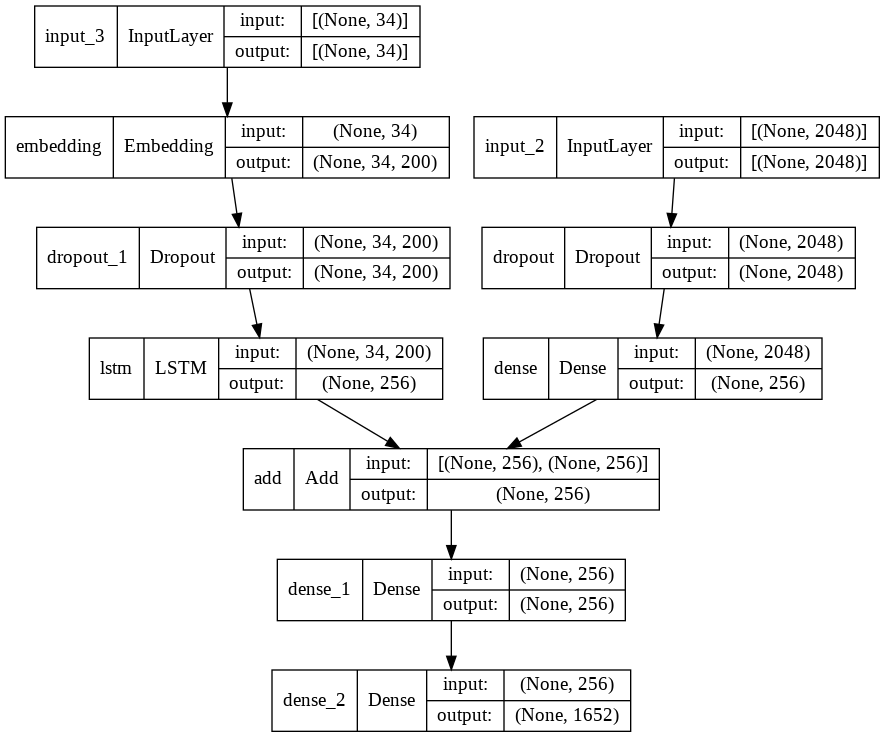

In [ ]:
plot_model(model,show_shapes = True)

##Step 10: Training the model

In [ ]:
model.layers[2].set_weights([emb_matrix])
model.layers[2].trainable = False
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
model.fit([X1, X2], y, epochs = 5, batch_size = 256)

Epoch 1/5
1142/1142 [==============================] - 687s 598ms/step - loss: 3.9199
Epoch 2/5
1142/1142 [==============================] - 682s 597ms/step - loss: 3.1688
Epoch 3/5
1142/1142 [==============================] - 677s 593ms/step - loss: 2.9363
Epoch 4/5
1142/1142 [==============================] - 677s 593ms/step - loss: 2.7818
Epoch 5/5
1142/1142 [==============================] - 676s 592ms/step - loss: 2.6673


##Step 11: Predicting the output

In [ ]:
def greedy_search(pic):
    start = 'startseq'
    for i in range(max_length):
        seq = [wordtoix[word] for word in start.split() if word in wordtoix]
        seq = pad_sequences([seq], maxlen = max_length)
        yhat = model.predict([pic, seq])
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        start += ' ' + word
        if word == 'endseq':
            break
    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

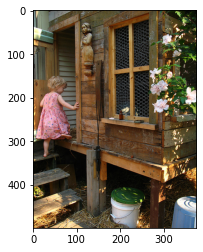

Greedy Search: young boy is standing in front of wooden fence


In [ ]:
pic = '1000268201_693b08cb0e.jpg'
image = encoding_train[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedy_search(image))

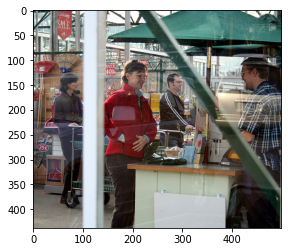

Greedy: two men stand in front of building


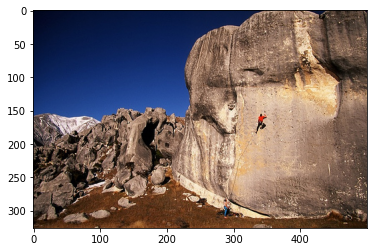

Greedy: man climbing rock face


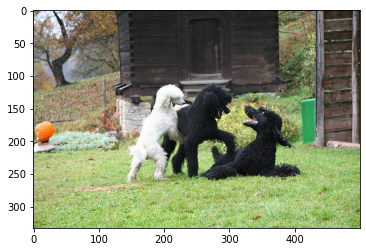

Greedy: black poodle is playing with black poodle


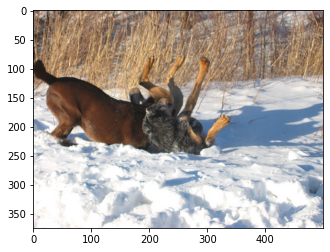

Greedy: two dogs are playing in the snow


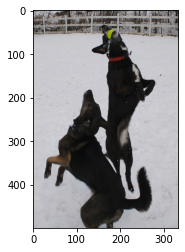

Greedy: black dog is jumping up in the snow


In [ ]:
for i in list(encoding_train.keys())[10:15]:
  image = encoding_train[i].reshape((1,2048))
  x=plt.imread(images+i)
  plt.imshow(x)
  plt.show()
  print("Greedy:",greedy_search(image))